# Transfer Learning with TensorFlow Part 2: Fine-Tuning



In [1]:
# Check the GPU
!nvidia-smi

Sun Feb  5 19:03:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    27W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions
In previous notebooks we've created a bunch of helper functions, we could rewrite them all but this is tedious.

So it's a good idea to put functions you use a lot for future use in some kind of script as below.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-05 19:03:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-05 19:03:41 (87.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import helper functions we're goint to use in this notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

> **NOTE:** If you're running this notebook in Colab, when it times out the `helper_functions.py` will be gone. Then it's important to redownload them every time you start a new adventure with experiments.

## Let's get some data

This time we're going to see how can we use pretrained models within `tf.keras.models.applications` and apply them to our own problem.

Link: https://www.tensorflow.org/api_docs/python/tf/keras/applications

In [4]:
 # Get the 10 percent data of 10 classes of Food101
 !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

 unzip_data('10_food_classes_10_percent.zip')

--2023-02-05 19:03:45--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.68.128, 74.125.24.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.68.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  22.9MB/s    in 8.0s    

2023-02-05 19:03:54 (20.0 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [5]:
# Check the number and subdirectories for our dataset
walk_through_dir('10_food_classes_10_percent')

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [6]:
# Creating train and test directiories
train_dir = '10_food_classes_10_percent/train'
test_dir = '10_food_classes_10_percent/test'

In [7]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                         image_size=IMG_SIZE,
                                                                         label_mode='categorical',
                                                                         batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                        image_size=IMG_SIZE,
                                                                        label_mode='categorical',
                                                                        batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In [9]:
# Check out class names
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [10]:
# See an example of a batch of data
import matplotlib.pyplot as plt

for images, labels in train_data_10_percent.take(1):
  print(images,labels)

tf.Tensor(
[[[[1.91841843e+02 1.61841843e+02 1.24556122e+02]
   [1.91596939e+02 1.62525513e+02 1.20811226e+02]
   [1.96219391e+02 1.65219391e+02 1.19219383e+02]
   ...
   [4.62038994e+01 2.30457611e+01 2.07651405e+01]
   [3.75204887e+01 1.85919323e+01 1.45919323e+01]
   [4.20457077e+01 2.58059788e+01 2.12192211e+01]]

  [[1.92928574e+02 1.62928574e+02 1.25642860e+02]
   [1.94857147e+02 1.65852051e+02 1.24005096e+02]
   [1.95571426e+02 1.64571426e+02 1.20030609e+02]
   ...
   [4.57654037e+01 1.99082603e+01 1.88368320e+01]
   [5.00407219e+01 2.64642277e+01 2.43213577e+01]
   [3.69234276e+01 1.61173077e+01 1.10203667e+01]]

  [[1.92709183e+02 1.63642853e+02 1.24204079e+02]
   [1.91755096e+02 1.62755096e+02 1.20897957e+02]
   [1.91239792e+02 1.61811218e+02 1.17474487e+02]
   ...
   [5.06633873e+01 2.04031868e+01 2.01123581e+01]
   [4.59183121e+01 1.76887569e+01 1.48316021e+01]
   [4.51887741e+01 1.77551956e+01 1.46123047e+01]]

  ...

  [[6.06632996e+01 2.62245388e+01 2.03724480e+01]
   [6

In [11]:
model = tf.keras.applications.efficientnet.EfficientNetB0()

21834768/21834768 [==============================] - 2s 0us/step


## Model 0: Building a transfer learning feature extraction model using the Keras Functional API

The Sequential API is straight-forward, it runs layers in sequential order.

The Fucntional API gives us a bit more flexibility.

In [12]:
# 1. Create a model with 'tf.keras.model.applications'
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-trained layers aren't updated)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. If using a model like ResNet50V2 you'll need to normalize inputs (no need for EfficientNet)
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base_model
x = base_model(inputs)
print(f'Shape after passing inputs through base model: {x.shape}')

# 6. Average poll the outputs of the base model (aggregate all the most important information to reduce the number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Combine the inputs and outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 10. Fit the model
history_0 = model_0.fit(train_data_10_percent, 
            epochs=5, 
            steps_per_epoch=len(train_data_10_percent),
            validation_data=test_data,
            validation_steps=int(0.25 * len(test_data)),
            callbacks=[create_tensorboard_callback(dir_name="transfer_learning", 
                                                   experiment_name="10_percent_feature_extraction"      
            )])

16705208/16705208 [==============================] - 2s 0us/step
Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20230205-190413
Epoch 1/5
24/24 [==============================] - 18s 254ms/step - loss: 1.8822 - accuracy: 0.4107 - val_loss: 1.2872 - val_accuracy: 0.7056
Epoch 2/5
24/24 [==============================] - 5s 183ms/step - loss: 1.0961 - accuracy: 0.7693 - val_loss: 0.8819 - val_accuracy: 0.7862
Epoch 3/5
24/24 [==============================] - 5s 182ms/step - loss: 0.7968 - accuracy: 0.8200 - val_loss: 0.6813 - val_accuracy: 0.8322
Epoch 4/5
24/24 [==============================] - 5s 184ms/step - loss: 0.6475 - accuracy: 0.8520 - val_loss: 0.6187 - val_accuracy: 0.8405
Epoch 5/5
24/24 [==============================] - 4s 146ms/step - loss: 0.5487 - accuracy: 0.8760 - val_loss: 0.5679 - val_accuracy: 0.8470


79/79 [==============================] - 7s 79ms/step - loss: 0.5565 - accuracy: 0.8696


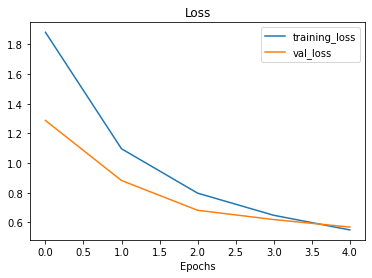

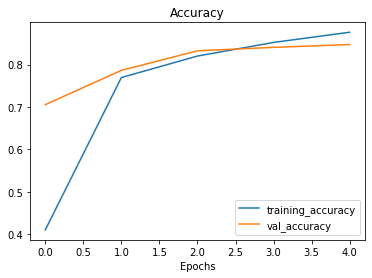

In [13]:
# Evaluate on full test set
model_0.evaluate(test_data)

plot_loss_curves(history_0)

In [14]:
# Check the layers in the base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name)

0 input_2
1 rescaling_1
2 normalization_1
3 tf.math.truediv_1
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_ac

In [15]:
# How about we get a summary of base model
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_1[0][0]']            
 )                              3)                                                   

In [16]:
# How about we get a summary of our model?
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


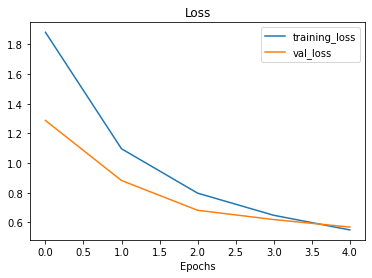

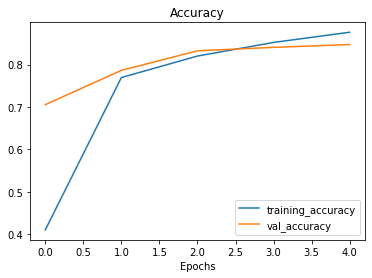

In [17]:
# Check out our model's training curver
plot_loss_curves(history_0)

## Getting a feature vector from the trained model

Let's demonstrate the GlobalAveragePooling2D layer...

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then it passes through GlobalAveragePooling2D it turns into (None, 1280).

Let's use a similar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [18]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor}\n")

# Pass the random tensor through a GlobalAveragePooling2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global average pooled random tensor:\n {global_average_pooled_tensor} \n")

# Check the shape of different tensors
print(f"Shape of input tensor: {input_tensor.shape}")
print(f"Shape of Global Average Pooled 2D tensor: {global_average_pooled_tensor.shape}")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]] 

Shape of input tensor: (1, 4, 4, 3)
Shape of Global Average Pooled 2D tensor: (1, 3)


In [19]:
# Let's replicate the Global Average Pooling 2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

> **PRACTICE**
Try to do the same as above but this time use `GlobalMaxPool2D` layer and see the results

In [20]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor}\n")

# Pass the random tensor through a GlobalMaxPool2D layer
global_max_pooling_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"2D Global Max Pooled random tensor: \n {global_max_pooling_tensor} \n")

# Check the shapes
print(f"Input tensor shape: {input_tensor.shape}")
print(f"Global Max Pooling 2D tensor shape: {global_max_pooling_tensor.shape}")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D Global Max Pooled random tensor: 
 [[0.9058464 1.1603122 1.6994323]] 

Input tensor shape: (1, 4, 4, 3)
Global Max Pooling 2D tensor shape: (1, 3)


In [21]:
# Let's try to replicate the Global Max Pooling 2D layer
tf.reduce_max(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.9058464, 1.1603122, 1.6994323]], dtype=float32)>

> **NOTE:** One of the reasons the feature extraction is named how it is is because what often happens is pretrained model outputs a **feature vector** (in form of long tensor of numbers which represent the learned representation of the model on a particular sample, in our case, this is the output of the `tf.keras.layers.GlobalAveragePooling2D()` layer) which can be used to extract patterns out of our own specific problem.

## Running a series of transfer learning experiments

We've seen incredible results transfer learning can get with only 10% percent of the training data, but how does it go with 1% of the training data? Let's set up some experiments to find out:
1. `model_1` - use feature extraction transfer learning with 1% of the training data with data augmentation
2. `model_2` - use feature extraction transfer learning with 10% of the training data with data augmentation
3. `model_3` - use fine-tuning transfer learning on the 10% of the training data with data augmentation
4. `model_4` - use fine-tuning transfer learning on 100% of the training data with data augmentation

> **Note: throughout all experiments the same test dataset will be used to evaluate our model. This ensures consistency across evaluation metrics.**

### Getting and preprocessing the data for `model_1`

In [22]:
# Download and unzip data - preprocessed from Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
unzip_data('10_food_classes_1_percent.zip')

--2023-02-05 19:05:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.128, 142.251.10.128, 142.251.12.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  19.9MB/s    in 7.7s    

2023-02-05 19:05:13 (16.4 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [23]:
# Create training and test dirs
train_dir_1_percent = "10_food_classes_1_percent/train"
test_dir_1_percent = "10_food_classes_1_percent/test"

In [24]:
# Check the number of images
walk_through_dir('10_food_classes_1_percent')

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'

In [25]:
# Setup data loaders
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent, 
                                                                           label_mode='categorical', 
                                                                           image_size=IMG_SIZE, 
                                                                           batch_size=BATCH_SIZE) # default value
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir, 
                                                                label_mode='categorical',
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation right into the model

To adda data augmentation right into the model we can use layers inside:
* `tf.keras.layers.preprocessing()`

The benefits are being described here:
https://www.tensorflow.org/tutorials/images/data_augmentation?hl=pl

Off the top of our heads, the benefits of using it inside the model are:
* preprocessing of the images happens on the GPU (which is faster then CPU)
* it happens only during training, so we can still export our model and use it elsewhere

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation with horizontal flipping, rotations, zooms etc
data_augmentation = keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    #preprocessing.Rescaling(1/255.) # Keep it for ResNet50V2, but EfficientNet has it built-in
], name='data_augmentation')

### Visualize our data augmentation layer (and see the effect on the data)

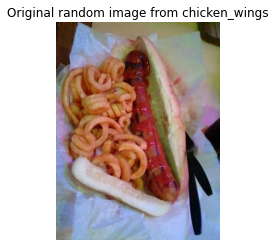

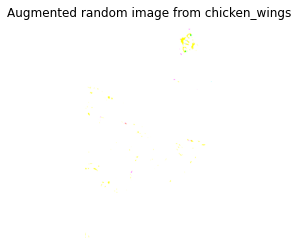

In [27]:
# View a random image and compare it to its augmented version
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data_1_percent.class_names)
target_dir = '10_food_classes_1_percent/train/' + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + '/' + random_image

# Read and plot the random image
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title('Original random image from ' + target_class)
plt.axis(False)

# Plot augmented random image
augmented_img = data_augmentation(img, training=True)
plt.figure()
plt.title('Augmented random image from ' + target_class)
plt.axis(False)
plt.imshow(augmented_img)


## Model 1: Feature Extraction transfer learning on 1% of the data with data augmentation

In [28]:
# Setup input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')

# Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# Give base_model ine inputs (after augmentation) and don't train it
x = base_model(x, training=False)

# Pool output features of the base model
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Put a dense layer on as the output
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# Make a model using inputs and outputs
model_1 = tf.keras.Model(inputs, outputs)

# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

# Fit the model
history_1_percent = model_1.fit(train_data_1_percent,
                                epochs=5,
                                steps_per_epoch=len(train_data_1_percent),
                                validation_data=test_data,
                                validation_steps=int(0.25*len(test_data)),
                                callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                       experiment_name='1_percent_data_aug')])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20230205-190518
Epoch 1/5


3/3 [==============================] - ETA: 0s - loss: 2.4351 - accuracy: 0.1000

3/3 [==============================] - 10s 2s/step - loss: 2.4351 - accuracy: 0.1000 - val_loss: 2.2382 - val_accuracy: 0.1957
Epoch 2/5
3/3 [==============================] - 4s 2s/step - loss: 2.2019 - accuracy: 0.2857 - val_loss: 2.0979 - val_accuracy: 0.2664
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 2.0043 - accuracy: 0.4000 - val_loss: 2.0051 - val_accuracy: 0.3339
Epoch 4/5
3/3 [==============================] - 4s 2s/step - loss: 1.8315 - accuracy: 0.4714 - val_loss: 1.9052 - val_accuracy: 0.3882
Epoch 5/5
3/3 [==============================] - 4s 2s/step - loss: 1.6168 - accuracy: 0.6571 - val_loss: 1.8120 - val_accuracy: 0.4507


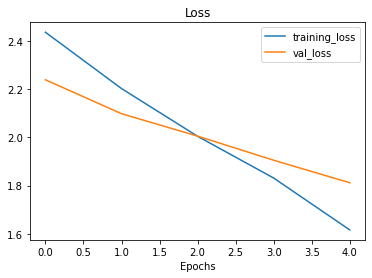

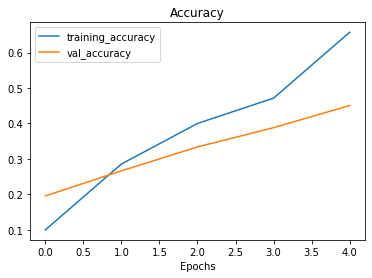

In [29]:
# How do the model with 1% data loss curves look alike
plot_loss_curves(history_1_percent)

In [30]:
# Check out our model summary 
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, 3)          0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [31]:
# Evaluate on full test dataset
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 6s 71ms/step - loss: 1.7935 - accuracy: 0.4748


[1.7935227155685425, 0.4747999906539917]

## Model 2: Feature Extraction transfer learning on 10% of the data with data augmentation

In [38]:
# Setup input shape and freeze the layers of the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create the input layer
inputs = layers.Input(shape=(224, 224, 3), name='input_layer')

# Create the data augmentation layer
x = data_augmentation(inputs)

# Create the base_model
x = base_model(x, training=False)

# Create a feature vector 
x = layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)

# Create a dense output layer
outputs = layers.Dense(10, activation='softmax', name='output_layer')(x)

# Create the model_2
model_2 = tf.keras.Model(inputs, outputs)

# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer='Adam',
                metrics=['accuracy'])

### Creating a ModelCheckpoint callback

The ModelCheckpoint callback intermediatelly saves our model (the full model or just the weights) during training. This is useful so we can come and start where we left off.

In [39]:
# Set checkpoint path
checkpoint_path = 'ten_percent_model_checkpoints_weights/checkpoint.ckpt'

# Create a ModelCheckpoint callback that saves the model's weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, 
                                                         save_weights_only=True,
                                                         save_best_only=True,
                                                         save_freq='epoch', # save every epoch
                                                         verbose=1)

In [40]:
# Fit the model
initial_epochs = 5

history_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                          epochs=initial_epochs,
                                          steps_per_epoch=len(train_data_10_percent),
                                          validation_data=test_data,
                                          validation_steps=int(0.25*len(test_data)),
                                          callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                  experiment_name='10_percent_data_aug'),
                                                      checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20230205-191402
Epoch 1/5


24/24 [==============================] - ETA: 0s - loss: 1.9711 - accuracy: 0.3747


Epoch 1: val_loss improved from inf to 1.41734, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 16s 425ms/step - loss: 1.9711 - accuracy: 0.3747 - val_loss: 1.4173 - val_accuracy: 0.6859
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.2970 - accuracy: 0.7080
Epoch 2: val_loss improved from 1.41734 to 0.97736, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 8s 316ms/step - loss: 1.2970 - accuracy: 0.7080 - val_loss: 0.9774 - val_accuracy: 0.7961
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 0.9911 - accuracy: 0.7587
Epoch 3: val_loss improved from 0.97736 to 0.79268, saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 12s 478ms/step - loss: 0.9911 - accuracy: 0.7587 - val_loss: 0.7927 - val_accuracy: 0.8125
Epoch 4/5
24/24 [==============================] - ETA: 

In [42]:
# What were model_0 results?
model_0.evaluate(test_data)

79/79 [==============================] - 6s 70ms/step - loss: 0.5565 - accuracy: 0.8696


[0.5565125942230225, 0.8695999979972839]

In [43]:
# Check the model_2 results on all test data 
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 6s 70ms/step - loss: 0.6340 - accuracy: 0.8360


[0.6340498924255371, 0.8360000252723694]

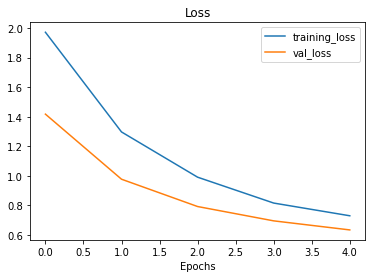

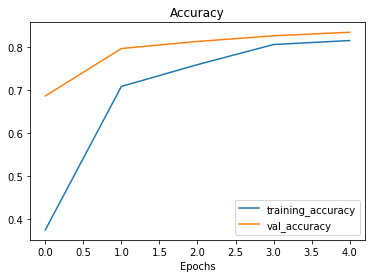

In [44]:
# Plot the loss curves
plot_loss_curves(history_10_percent_data_aug)

### Loading in checkpointed weights

Loading in a checkpointed weights returns a model to a specific checkpoint

In [45]:
# Load in saved model weights and evaluate model
model_2.load_weights(checkpoint_path)

In [46]:
# Evaluate model_2 with loaded weights
loaded_weights_model_results = model_2.evaluate(test_data)

79/79 [==============================] - 7s 83ms/step - loss: 0.6341 - accuracy: 0.8360


In [47]:
# If results from previously evaluated model_2 match the loaded weights model
loaded_weights_model_results == results_10_percent_data_aug

False

In [48]:
# Check to see if loaded model results are very close to our previous non-loaded model results
import numpy as np
np.isclose(np.array(loaded_weights_model_results), np.array(results_10_percent_data_aug))

array([ True,  True])

In [49]:
# Check the difference
print(np.array(results_10_percent_data_aug)-np.array(loaded_weights_model_results))

[-1.78813934e-07  0.00000000e+00]


## Model 3: Fine-tuning an existing model on 10% of training data

> **NOTE:** Fine-tuning usually works best **after** training a feature extraction model for a few epochs with large amounts of training data.

In [51]:
# Layers in model_2
model_2.layers

In [52]:
# Are these layers trainable?
for layer in model_2.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f428a2e36d0> True
<keras.engine.sequential.Sequential object at 0x7f428d2c1940> True
<keras.engine.functional.Functional object at 0x7f4207018fa0> False
<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x7f428a44bf10> True
<keras.layers.core.dense.Dense object at 0x7f4207018ac0> True


In [54]:
# What layers are in the base_model (EfficientNetB0) and are they trainable
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 tf.math.truediv_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [55]:
# How many trainable variables in our base model
print(len(model_2.layers[2].trainable_variables))

0


In [56]:
# To begin fine-tuning, let's start by settign the last 10 layers of pur base_model.trainable = True
base_model.trainable = True

# Freeze all layers expect for last ten:
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile (every time we make a change)
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # when fine-tuning, typically lower the learning rate by 10x
                metrics=['accuracy'])

> **NOTE:** When using fine-tuning, best practice is to lower your learning rate by some rate. There are no said rules, however good practice is to go with 10x less than earlier chosen one. However you can try and experiment with this by yourself.

In [58]:
# Check which layers are tuneable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_5 False
1 rescaling_4 False
2 normalization_4 False
3 tf.math.truediv_4 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeez

In [59]:
# Now we've unfrozern some layers closer to the top, how many trainable are there then?
print(len(model_2.trainable_variables))

12


In [60]:
# Fine-tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2, except with more trainable layers)
history_fine_10_percent_data_aug = model_2.fit(train_data_10_percent,
                                               epochs=fine_tune_epochs,
                                               steps_per_epoch=len(train_data_10_percent),
                                               validation_data=test_data,
                                               validation_steps=int(0.25*len(test_data)),
                                               initial_epoch=history_10_percent_data_aug.epoch[-1], # start training from previous last epoch
                                               callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                                      experiment_name='10_percent_fine_tune_last_10')])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20230205-195120
Epoch 5/10


24/24 [==============================] - ETA: 0s - loss: 0.5960 - accuracy: 0.8360

24/24 [==============================] - 17s 419ms/step - loss: 0.5960 - accuracy: 0.8360 - val_loss: 0.4864 - val_accuracy: 0.8536
Epoch 6/10
24/24 [==============================] - 8s 323ms/step - loss: 0.4936 - accuracy: 0.8587 - val_loss: 0.4849 - val_accuracy: 0.8421
Epoch 7/10
24/24 [==============================] - 12s 495ms/step - loss: 0.4191 - accuracy: 0.8840 - val_loss: 0.4732 - val_accuracy: 0.8536
Epoch 8/10
24/24 [==============================] - 7s 292ms/step - loss: 0.3874 - accuracy: 0.8813 - val_loss: 0.4568 - val_accuracy: 0.8470
Epoch 9/10
24/24 [==============================] - 8s 302ms/step - loss: 0.3444 - accuracy: 0.8933 - val_loss: 0.4239 - val_accuracy: 0.8651
Epoch 10/10
24/24 [==============================] - 9s 380ms/step - loss: 0.3065 - accuracy: 0.9053 - val_loss: 0.4362 - val_accuracy: 0.8618


In [61]:
# Evaluate fine-tuned model_3 (which is actually model_2 fine tuned for 5 epochs)
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.4420 - accuracy: 0.8568


In [62]:
results_10_percent_data_aug

[0.6340498924255371, 0.8360000252723694]

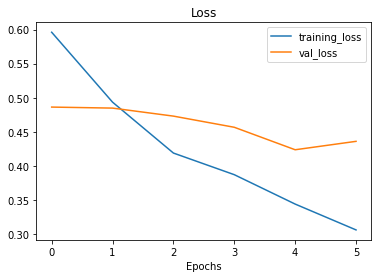

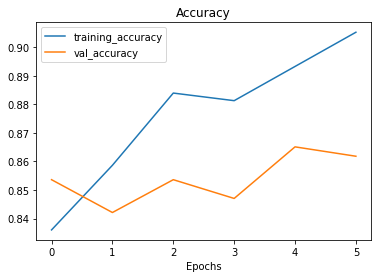

In [63]:
# Check out the loss curves of fine-tuned model
plot_loss_curves(history_fine_10_percent_data_aug)

The `plot_loss_curves` function works great with models which have only been fit once, however we want something to compare one series of running `fit()` with another. For example before and after fine tuning.

In [ ]:
# Let's create a function to compare histories
def compare_histories(original_history, new_history, inital_epochs=5):
  """
  Compares two TensorFlow History objects.
  """
  # Get the original history measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combine original history
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']